In [24]:
from plane_cylinder_projections import *
from visualizations import (plot_ground_truth_3d, validation_of_3d_tangent_estimation, show_borehole_image,
                            show_gradients_magnitudes, plot_tangents_and_gradients_field, plot_3d_scatter)
from simulations import DEFAULT_PLANE_ANGLES, create_planes_projection, simulated_splat_image, get_3d_tangent_estimation
from image_processing import extract_2d_gradients_from_image
from constants import *
import matplotlib.pyplot as plt
import numpy as np
from skimage import filters
from plane_extraction import get_cross_products
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


| Plane and normal $\vec{p}$ | Plane normal vector dip $\delta$ , azimuth $\alpha$ |
| :--: |  :--: | 
|  ![](report/plane_normal_definition.png) | ![](report/normal_definition.png) |

- If $\delta=0$, horizontal slice ($alpha$ is not informative by the way), we'll get a line in the images
- If $\delta=90°$, vertical plane (corresponds to infinite amplitude oscillation = vertical line).

In [25]:
# First, let's define some groundtruth planes (dip, azimut)
mixed_slices = False
if mixed_slices:
    plane_angle = torch.tensor(
        [
            [0., 0.,  -0.3],
            [torch.pi/4, torch.pi/4, 0.],
            [0.8*torch.pi/2., torch.pi/4, -1.],
            [0.9*torch.pi/2., torch.pi/3, -0.5],
            [0.1, torch.pi/2, -1.2],
        ]
    )
else:
    # plane_angle = torch.tensor(
    #     [
    #         [torch.pi/4, torch.pi/4, 0.],
    #         [torch.pi/4, torch.pi/4, -0.3],
    #         [torch.pi/4, torch.pi/4, -0.6],
    #         [torch.pi/4, torch.pi/4, -0.8],
    #     ]
    # )
    plane_angle = torch.tensor(
        [
            [0.8*torch.pi/4, torch.pi/4, -0.2],
            [torch.pi/4, 0.99*torch.pi/4, -0.3],
            [1.02*torch.pi/4, torch.pi/4, -0.6],
            [torch.pi/4, 1.01*torch.pi/4, -0.8],
        ]
    )
plane_angle.shape

torch.Size([4, 3])

In [26]:
plane_angle = torch.tensor(
[
    [0.0, 0., 0.1],
    [0.1, 0., 0.3],
    [0.2, 0., 0.5],
    [0.3, 0., 0.8],
]
)

In [50]:
plane_angle = torch.tensor(
[
    [0.0, 0., 0.1],
    [0.1, 0., 0.3],
    [0.1, 0.5, 0.4],
    [0.3, 0., 0.5],
    [0.5, 0., 0.7],
    [0.5, -0.5, 0.8],
]
)

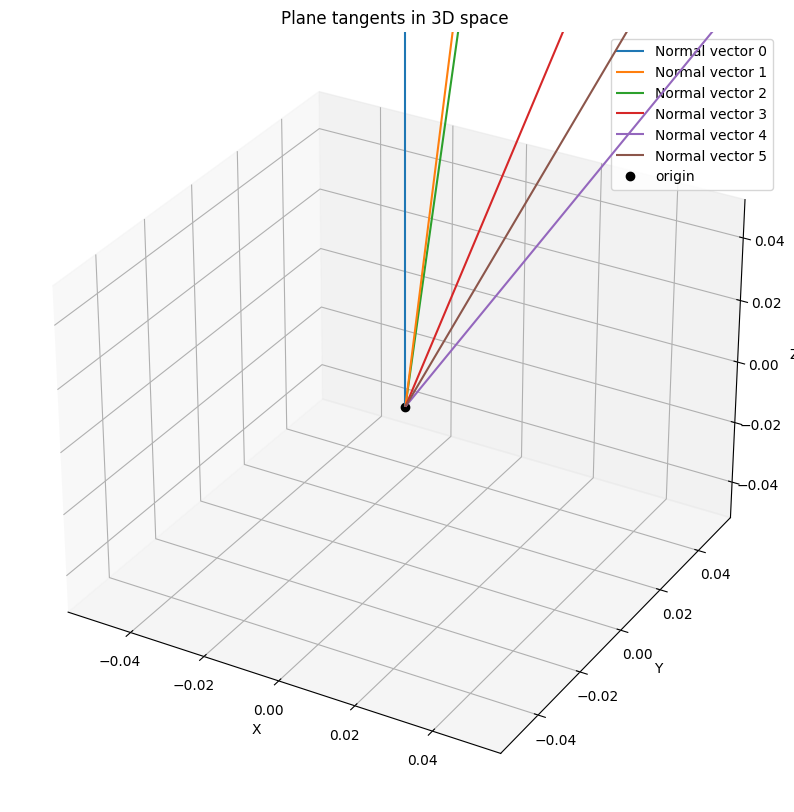

In [51]:
normals = angles_to_normal_vector(plane_angle)
plot_3d_scatter(point_cloud=None, vects=normals)

In [52]:
# Let's sample the azimuth coordinates and compute the altitude of the planes
azimuth_coordinates_phi, altitude_z = create_planes_projection(plane_angle)
p3D_gt = angle_to_3d_vector(azimuth_coordinates_phi, altitude_z=altitude_z) # [N, L, 3]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


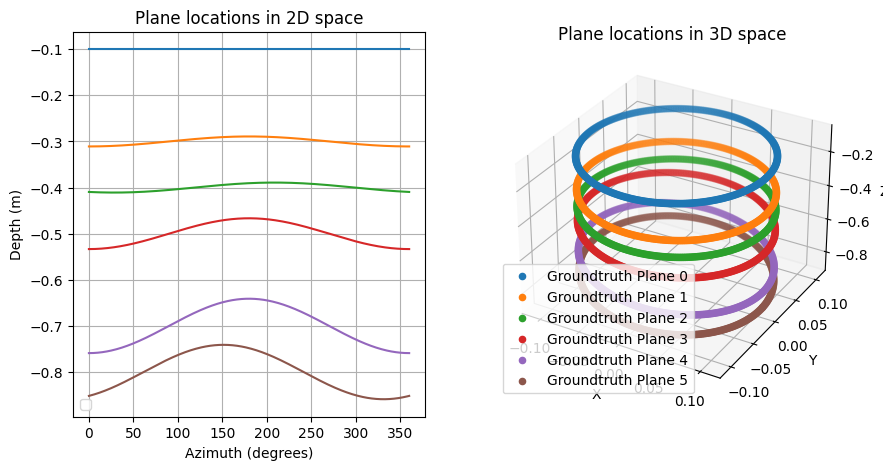

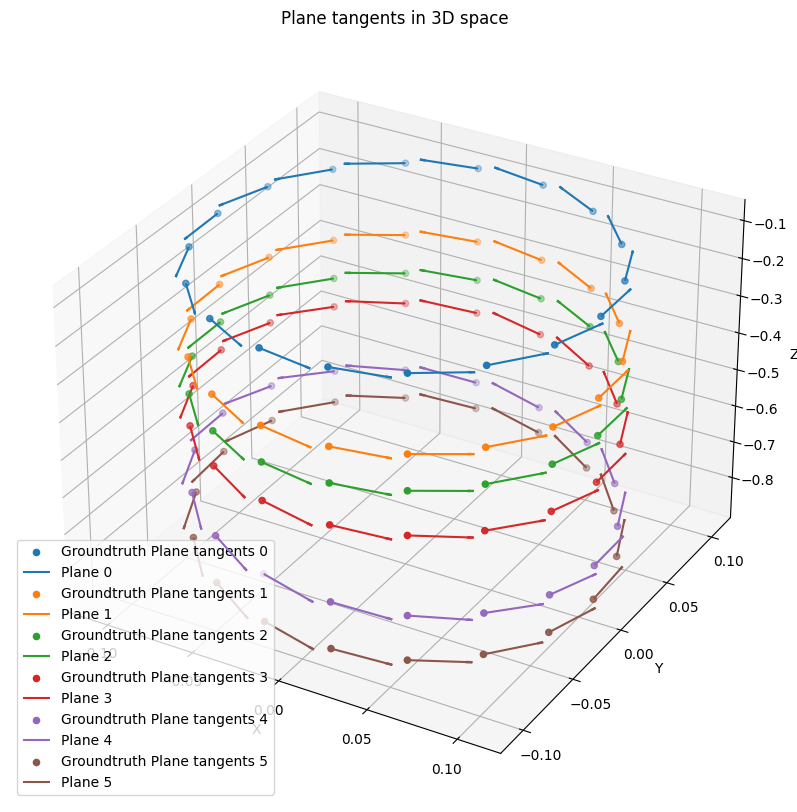

In [53]:
plot_ground_truth_3d(
    azimuth_coordinates_phi,
    altitude_z,
    p3D_gt
)

In [54]:
groundtruth_grad_list_3d = get_3d_tangent_estimation(azimuth_coordinates_phi, altitude_z)

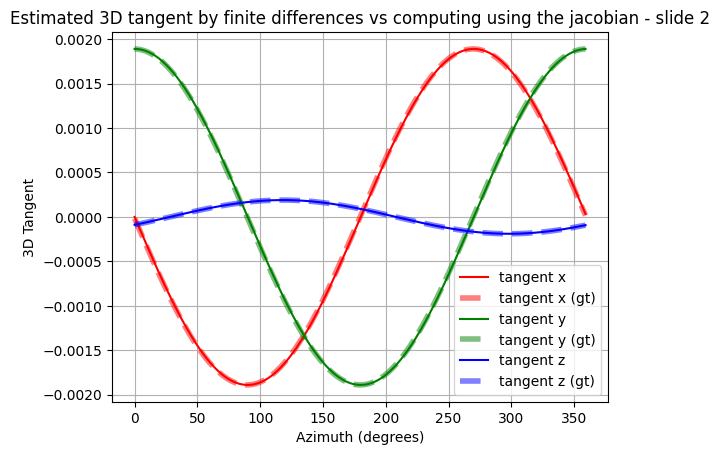

In [55]:
# Computation of the tangent vectors using the jacobian of `image_vector_to_3d_plane_tangent`
# Not normalized!
validation_of_3d_tangent_estimation(
    azimuth_coordinates_phi,
    groundtruth_grad_list_3d,
    p3D_gt=p3D_gt,
    batches_index=[2]
)

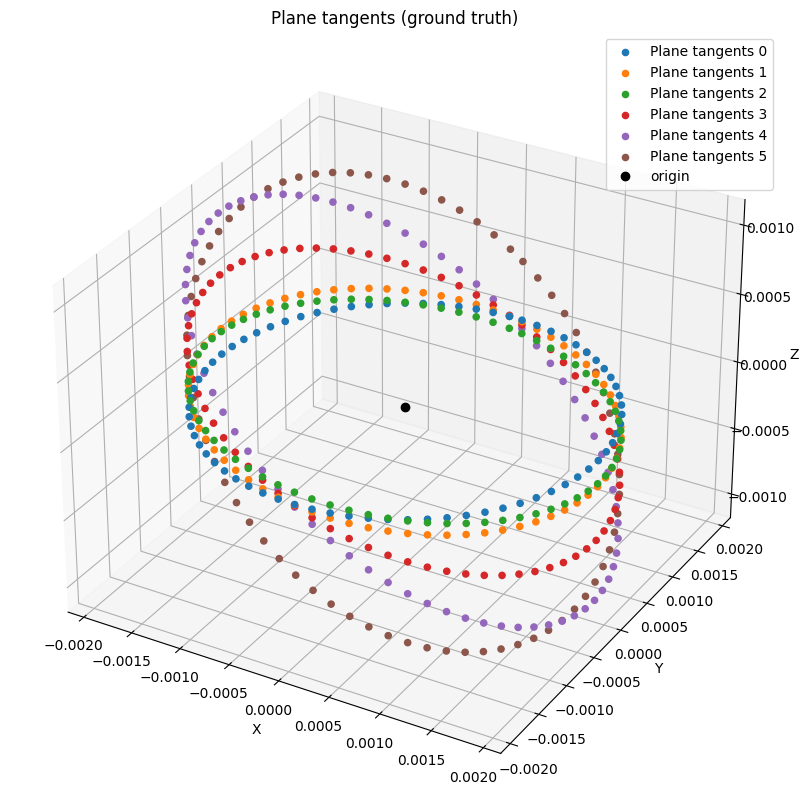

In [56]:
plot_3d_scatter(groundtruth_grad_list_3d[:, ::5, :], label="Plane tangents", title="Plane tangents (ground truth)") #.shape


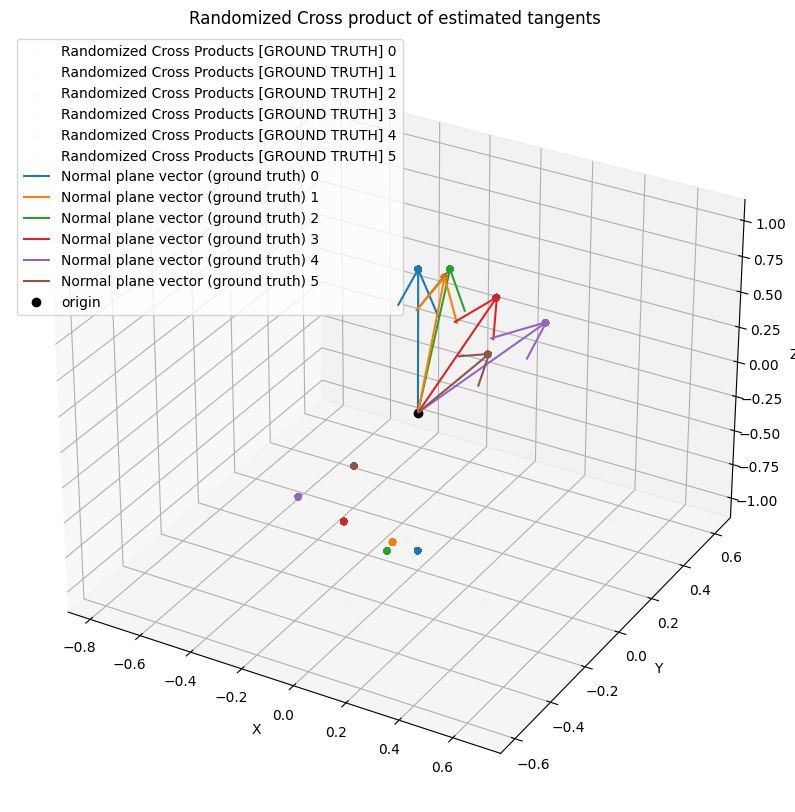

In [57]:
# plot_cross_products(cross_product_estimated)
cross_product_gt, cross_product_norm_gt = get_cross_products(groundtruth_grad_list_3d, num_points=1000)
cross_product_gt.shape
plot_3d_scatter(
    cross_product_gt,
    vects=normals,
    alpha=0.01,
    # colors="tab:cyan",
    label="Randomized Cross Products [GROUND TRUTH]",
    label_vector="Normal plane vector (ground truth)",
    title="Randomized Cross product of estimated tangents"
)


# Images
- 1/ Synthesize a borehole image with planar sections (and a bit of noise) from the known groundtruth orientations.
- 2/ Detect and select areas of relevant gradients. Extract a list of 2D gradient vectors (and tengeants) and their corresponding 2D locations.
- 3/ Project these 2D locations onto the 3D cylinder, find the 3D tangeant.
- 4/ Extract the plane normals by randomly sampling the 3D tangent vectors and computing the cross products 

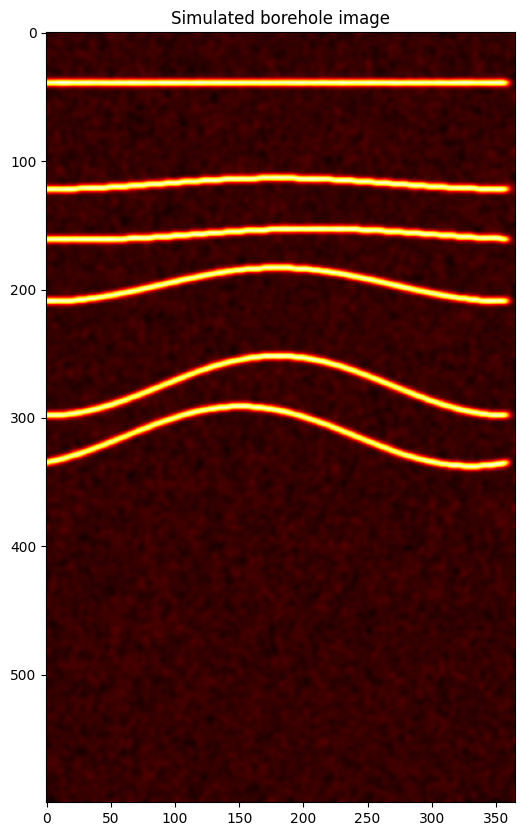

In [58]:
img = simulated_splat_image(azimuth_coordinates_phi, altitude_z)
show_borehole_image(img)

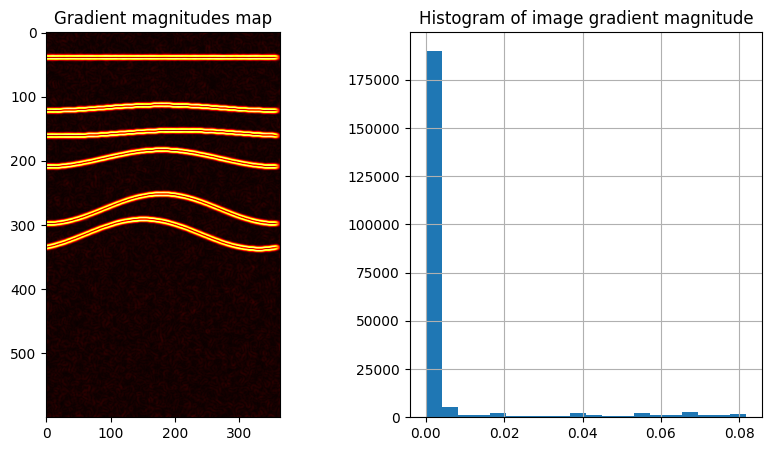

In [59]:
img_grad =filters.sobel(img)
show_gradients_magnitudes(img_grad)

In [60]:
img_grad_h, img_grad_v, img_grad, coords = extract_2d_gradients_from_image(img)

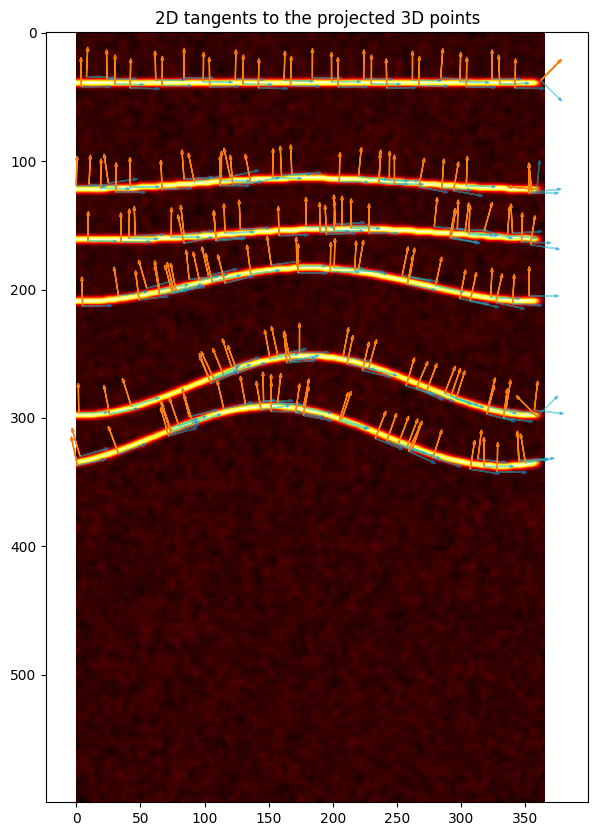

In [61]:
plot_tangents_and_gradients_field(coords, img_grad_h, img_grad_v, img)

In [62]:
# Compute the correctly scaled tangent vectors (in SI units, angles in radians, altitudes in meters)
tan_vec_2d = get_tangent_vec_from_gradients(img_grad_h, img_grad_v, normalize=False)

In [63]:
img_coords = torch.from_numpy(coords).float()
p3D_est = angle_to_3d_vector(np.deg2rad(img_coords[:, 1]), -img_coords[:, 0]*DEPTH_STEP).unsqueeze(0)

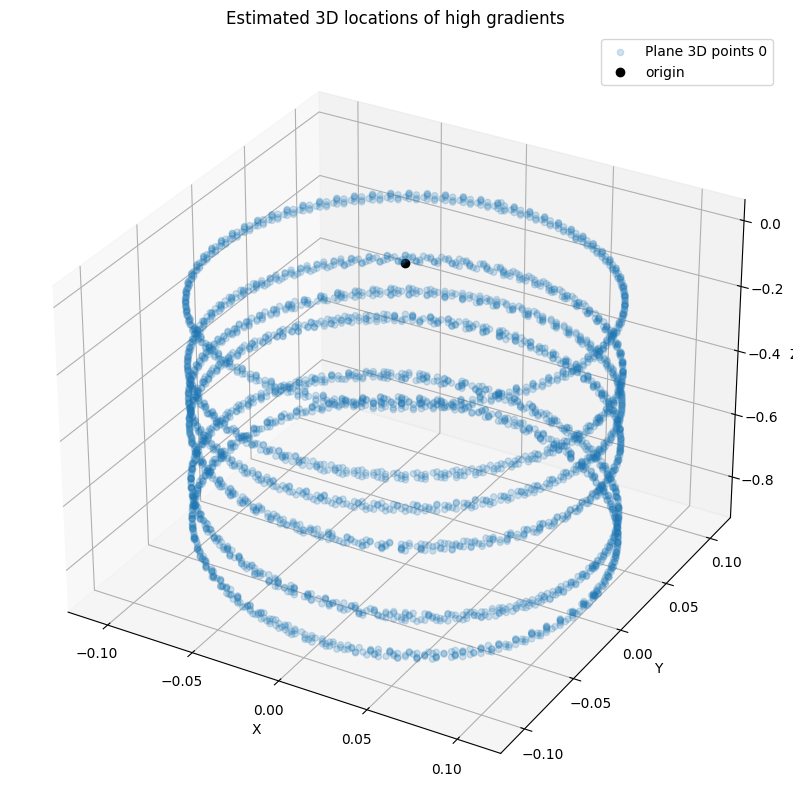

In [72]:
plot_3d_scatter(p3D_est[:, ::5], title="Estimated 3D locations of high gradients", alpha=0.2)

In [73]:
# Compute the 3D tangent vectors (and normalize)
img_coords = torch.from_numpy(coords).float()
p3D_est = angle_to_3d_vector(np.deg2rad(img_coords[:, 1]), -img_coords[:, 0]*DEPTH_STEP).unsqueeze(0)

azi_list = torch.deg2rad(img_coords[:, 1]).unsqueeze(0)
alt_list = -img_coords[:, 0]*DEPTH_STEP
tangent = np.array([
    -img_grad_v, # y 
    img_grad_h,
]).T
tangent.shape
tangents_3d = []
for idx in range(azi_list.shape[1]):
    azi = azi_list[0, idx]
    alt = alt_list[idx]
    delta_azi = tan_vec_2d[idx, 0]
    delta_alt = tan_vec_2d[idx, 1]
    tan3d = image_vector_to_3d_plane_tangent(azi, alt, delta_azi, delta_alt)
    tan3d = tan3d / tan3d.norm() # normalize the 3D tangent
    tangents_3d.append(tan3d)
tangents_3d = torch.stack(tangents_3d, dim=0).unsqueeze(0)

In [74]:
cross_product_estimated, cross_product_norm_estim = get_cross_products(tangents_3d, num_points=10000)

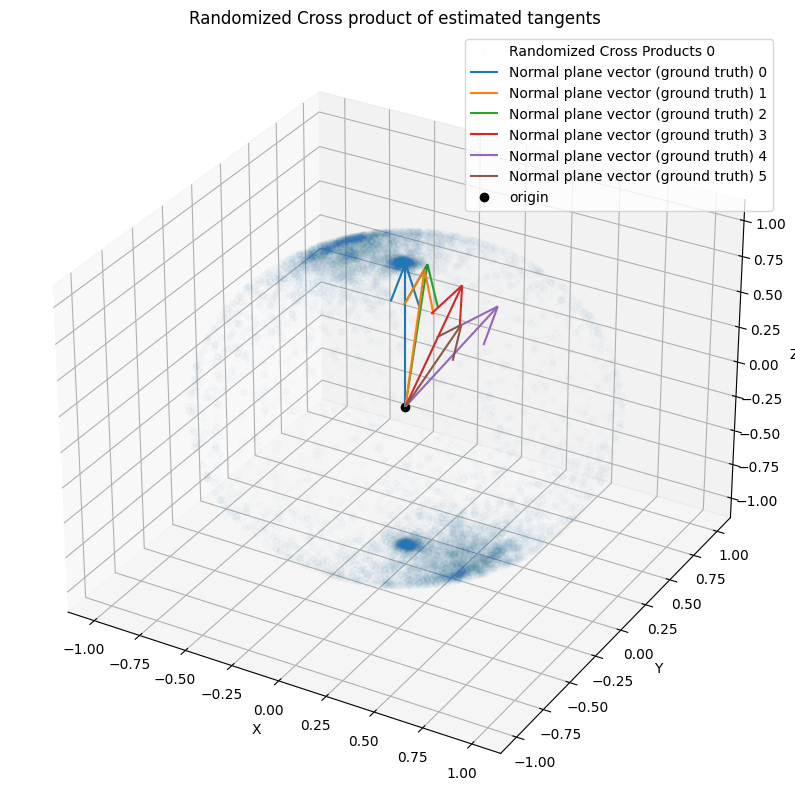

In [75]:
plot_3d_scatter(
    point_cloud=cross_product_estimated,
    # sizes=cross_product_norm_estim,
    # vectors = normals,
    vects=normals,
    alpha=0.01,
    # fixed="tab:cyan",
    label="Randomized Cross Products",
    label_vector="Normal plane vector (ground truth)",
    title="Randomized Cross product of estimated tangents")

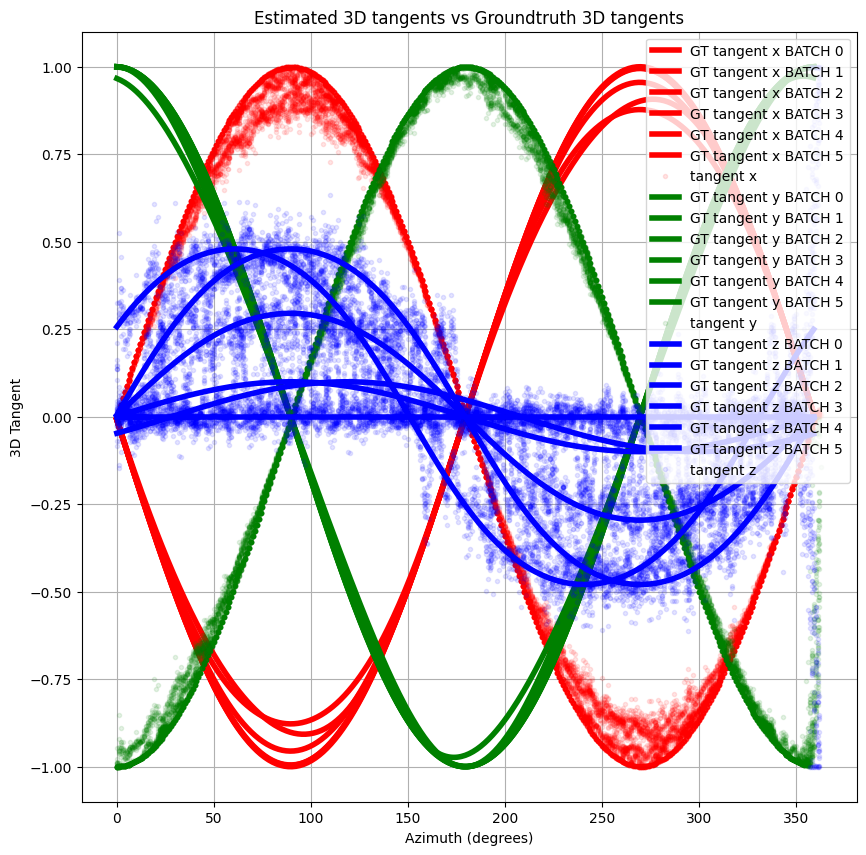

In [76]:
tangent3d = (p3D_gt[..., 1:, :] - p3D_gt[..., :-1, :])
tangent3d = tangent3d / tangent3d.norm(dim=-1, keepdim=True)
plt.figure(figsize=(10, 10))
for dim_idx, dim_name, dim_color  in zip(range(3), "xyz", "rgb"): 
    for batch_idx in range(azimuth_coordinates_phi.shape[0]):
        plt.plot(
            torch.rad2deg(azimuth_coordinates_phi[batch_idx, :-1]),
            tangent3d[batch_idx,  :, dim_idx],
            "-",
            color=dim_color,
            linewidth=4, alpha=1.,
            label=f"GT tangent {dim_name} BATCH {batch_idx}"
        )
    for batch_idx in range(azi_list.shape[0]):
        plt.plot(torch.rad2deg(azi_list[batch_idx]), -tangents_3d[batch_idx, :, dim_idx], "."+dim_color, label=f"tangent {dim_name}", alpha=0.1)
plt.xlabel("Azimuth (degrees)")
plt.ylabel("3D Tangent")
plt.legend()
plt.grid()
plt.title("Estimated 3D tangents vs Groundtruth 3D tangents")
plt.show()